In [1]:
import warnings
warnings.filterwarnings('ignore')

#import dependancies 
import pickle
import pandas as pd
import numpy as np
from rdkit import Chem
import torch
from os import path
import matplotlib.pyplot as plt

#import pkasolver
import pkasolver
from pkasolver.query import QueryModel
from pkasolver.ml_architecture import GINPairV1
from pkasolver.query import draw_pka_map 
from pkasolver.query import calculate_microstate_pka_values, draw_pka_reactions
from IPython.display import display
from IPython.display import HTML

#load trained model
base_path=path.dirname(pkasolver.__file__)


#import MolGpKa
from predict_pka import *
from protonate import *

#import vizualizing modules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import rdkit

## Functions

### For Chem Axon

In [2]:
def OneToZeroStart(atomList):
    atoms=[]
    if len(atomList)== 1:
        new=(atomList[0] -1)
        atoms.append(new)
    else:
        for i in atomList:
            new=(i-1)
            atoms.append(new)
    return(atoms)

### For table formating

In [3]:
def RunPkasolver(x):#takes input of smile object
    mol=Chem.MolFromSmiles(x)
    protonation_states = calculate_microstate_pka_values(mol) #performs internal calculations and stores as object
    sites=len(protonation_states) #get the number of ionization sites 
    
    lst=[]
    depSmi=[]
    proSmi=[]
    idx=[]
    for j in range(len(protonation_states)):
        state=protonation_states[j]
        depSmi.append(Chem.MolToSmiles(state.deprotonated_mol))
        proSmi.append(Chem.MolToSmiles(state.protonated_mol))
        idx.append(state.reaction_center_idx)
        lst.append(round(state.pka,2)) #get pka values for all sites for a given molecule store in a list
    yield sites,lst,proSmi,depSmi,idx

In [4]:
def RunMolGpKa(x):
    mol = Chem.MolFromSmiles(x)
    base_dict, acid_dict,new_idx,m = predict(mol) ##amended to return new index
    smi=Chem.MolToSmiles(Chem.MolFromSmiles(Chem.MolToSmiles(m)))
    yield acid_dict, base_dict, new_idx,smi

In [5]:
def MakeMultilevelHeader(dict,tuple_lst):
    #make a multi level index using the tuples where level 0 is the category and level 1 is the atom index
    cols=pd.MultiIndex.from_tuples(tuple_lst)

    #make dataframe with pka values and multilevel column headers (transpose so that multilevel lables are column headers and not index
    df=pd.DataFrame([dict.values()],columns=cols)
    return df

In [6]:
#merge columns with same names together
def MergeValues(x):
    return ', '.join(x[x.notnull()])

In [7]:
def SortLow2High(df):
    col_avg=[]
    col_idx=[]
    #look at only pka data (removes calculator name col and acid/base row)
    for c in df.iloc[1:4,1:]:
        col_idx.append(c)
        #average of column
        col_val=round(df.iloc[1:4,c].mean(),2)
        col_avg.append(col_val)
    #make dictionary with column index (key) and column average
    d=dict(zip(col_idx,col_avg))
    #sort sort (low to high) columns based on value, if value is the same then sort by key
    sort_d=dict(sorted(d.items(), key=lambda kv: (kv[1], kv[0])))
    col_order=list(sort_d.keys())
    #reindex dataframe so with new column order
    new=df.reindex(columns=col_order)
    #make the last row (atom#_) row the header
    new.rename(columns=new.iloc[4],inplace=True)
    #remove the last row
    new.drop(new.index[4], inplace = True)
    #add calculator column
    new.insert(0,'Calculator',['','Chem Axon','MolGpKa','pKaSolver'])
    return new

In [8]:
def FormatTable(parent):
    
    ## this code is only relevant for how I got chem axon data for testing
    axon=ax[ax['Input_SMILES']==parent].reset_index(drop=True)
    axon.dropna(axis=1,inplace=True)
    
    idx=0
    ca_dict={}
    ca_tuples=[]
    #'cat' as in category so as not to overwrite the 'type' function
    for c in axon:
       if 'apKa' in c:
           cat='acid'
           pka=axon[c][:1].iloc[0]
           if ',' in str(axon['new_index'][0]):
               atom=int(axon['new_index'][:1].iloc[0].split(',')[idx])
           else:
               atom=int(axon['new_index'])
           tuple=(cat,atom)
           ca_dict.update({tuple:pka})
           ca_tuples.append(tuple)
           idx=idx+1
       elif 'bpKa' in c:
           cat='base'
           pka=axon[c][:1].iloc[0]
           if ',' in str(axon['new_index'][0]):
               atom=int(axon['new_index'][:1].iloc[0].split(',')[idx])
           else:
               atom=int(axon['new_index'])
           tuple=(cat,atom)
           ca_dict.update({tuple:pka})
           ca_tuples.append(tuple)
           idx=idx+1
    #make dataframe with multilevel header, 
    #where header[0] is the type (acid or base) and header[1] is the atom index
    #ca_dict is made up of the {tuple(type,atom): pka}
    #making sure chem axon data is in this formating is crucial
    ca_df=MakeMultilevelHeader(ca_dict,ca_tuples)
    
    ###### non chem axon code#####
    
    #get pka from calculators
    molg=RunMolGpKa(parent)
    solver=RunPkasolver(parent)
    
    #make dictionary of type, atom index (key) and pka(value)
    for a,b,idx,smi in molg:
        #make new dictionary with new acid index (key) and acid pka (value)
        new_acid_dict=dict(zip(idx,a.values()))
        
        mg_dict={}
        mg_tuples=[]
        for k,v in new_acid_dict.items():
            cat='acid'
            atom=k
            pka=round(v,2)
            mg_tuples.append((cat,atom))
            mg_dict.update({(cat,atom):pka})
        
        for k,v in b.items():
            cat='base'
            atom=k
            pka=round(v,2)
            mg_tuples.append((cat,atom))
            mg_dict.update({(cat,atom):pka})
            
    #pkasolver does not provide acid/base information
    for n,p,ds,ps,i in solver:
        solver_pka=p
        solver_idx=i
    solver_dict=dict(zip(solver_pka,solver_idx))
    
    
    ####Molgpka
    #make dataframe from dictionary and tuples; tuples are column multilevel headers
    molg_df=MakeMultilevelHeader(mg_dict,mg_tuples)
    
    ####pkasolver
    #make a dataframe from dictionary 
    solver_df=pd.DataFrame([solver_dict.keys()],columns=solver_dict.values())
    
    #combine pka values with the same atom index
    solver_df=solver_df.groupby(level=0,axis=1).apply(lambda x:x.apply(list,axis=1))
    
    #concat chem axon and molg pka using multilevel index
    both=pd.concat([ca_df,molg_df],ignore_index=True)
    
    #grab categrory information from level 0 of multilevel indexing,make it a new row
    both.loc[len(both)]=both.columns.get_level_values(0)
    
    #drop top level in multilevelindexing
    both.columns=both.columns.droplevel()
    
    #group pka preds for a particular site in chemaxon/molg df
    test=both.groupby(level=0,axis=1).apply(lambda x:x.apply(list,axis=1))
    
    #handle cases where pkasolver has more or fewer sites than molg/chemaxon
    #note: comparing num of pka preds/site for pkasolver and molg because I doubt chemaxon will predict >1 pka/site
    for c in solver_df.columns:
        v=solver_df[c][0]
        if c in test.columns:
            ca=test.loc[0,c]
            mg=test.loc[1,c]
            #if there are more pkasolver preds for a particular site than preds from molg
            if len(v) > len(mg):       
                for i in range(len(mg)):
                    if np.isnan(ca[i])==False:
                        #get average pka for molg and chemaxon at a particular site/category
                        avg=((ca[i]+mg[i])/len(mg))
                    else:
                        avg=mg[i]
                    #sort solver preds based on how close (smallest diff) pred is to avg
                    tmp=sorted(v,key=lambda x: abs(avg-x)) 
                    solver_df[c][0]=tmp
                    
            #if there are more molg preds for particular site than preds from pkasolver
            #just concat because all values will be low --> high
            else:
                all=pd.concat([test,solver_df],ignore_index=True)
        else:
            all=pd.concat([test,solver_df],ignore_index=True)
  
    #add 'Calculators' column
    all.insert(0,'Calculator',['Chem Axon','MolGpKa',' ','pKaSolver'])
    
    #sort by calculator so that acid/base row is at the top
    all.sort_values(by='Calculator',ignore_index=True,inplace=True)

     #seperate out listed values from pkasolver  
    for c in all.iloc[1:,1:].columns:
        for i in all.iloc[1:,1:].index:
            x=all[c][i]
            if np.isnan(x).all()==True:
                all.loc[i,c]=np.nan
            elif len(x) > 1:
                    all.loc[i,[c,str(c)]]=x[0],x[1] #duplicate columns names, must store one as a string and one as int
            else:
                    all.loc[i,c]=x[0]
    #separate out type
    for c in all.iloc[1:,1:].columns:
        for t in all.iloc[:1,:1].index:
            x=all[c][t]
            if isinstance(x, (str,float)):
                break
            elif len(x) > 1:
               all.loc[t,[c,str(c)]]=x[0],x[1] #duplicate columns names, must store one as a string and one as int
            else:
                    all.loc[t,c]=x[0]
            
    #add 'atom#_' prefix
    all=all.iloc[:,1:].add_prefix('atom#_')
    
    #add 'Calculators' column
    all.insert(0,'Calculator',[' ','Chem Axon','MolGpKa','pKaSolver'])
    
    ## temporary formatting for column sorting 
    ## needed because of duplicate column names
    #add atom header as a row
    all.loc[len(all)]=all.columns.get_level_values(0)
    
    #rename columns as 0,1,2,3...n
    all.columns=range(all.columns.size)

    #sort table for lowest avg. pka to highest avg. pka
    table=SortLow2High(all)
    return table

### load and format chem axon data for looping

In [9]:
#chem axon data
#format chem axon output file into table
axon_res=pd.read_table('./ChemAxonExamples/ComparisonTableEx_CaResults.txt')
input=pd.read_table('./ChemAxonExamples/ComparisonTableEx.txt',header=None)

idx=[]
for i in input.index:
    id=i+1
    idx.append(id)
input.insert(0,'id',idx)
input.rename(columns={0:'Input_SMILES'},inplace=True)
ax=pd.merge(input,axon_res, on='id')

In [10]:
new_idx=[]
for i in ax.index:
    if len(ax['atoms'][i])>1:
        idx=ax['atoms'][i].split(',')
        idx=[int(x) for x in idx]
        new=OneToZeroStart(idx)
        new_idx.append(str(new).replace('[','').replace(']','').replace("'",""))
    else:
        idx=ax['atoms'][i]
        new=int(idx)-1
        new_idx.append(new)
ax['new_index']=new_idx
ax

,id,Input_SMILES,apKa1,apKa2,bpKa1,bpKa2,atoms,new_index
0,1,O=[N+]([O-])c1ccc(O)cc1,7.07,NaN,NaN,NaN,8,7
1,2,CCC(=O)O,4.75,NaN,NaN,NaN,5,4
2,3,Nc1ccccc1,NaN,NaN,4.64,NaN,1,0
3,4,O=C(O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)F,1.65,NaN,NaN,NaN,3,2
4,5,CC(C)C(N)C(=O)O,2.72,NaN,9.60,NaN,"8,5","7, 4"
5,6,c1ccc2nnccc2c1,NaN,NaN,3.07,NaN,6,5
6,7,NC1CCc2ccccc21,NaN,NaN,9.54,NaN,1,0
7,8,Sc1ccccc1,6.64,NaN,NaN,NaN,1,0
8,9,CC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2,NaN,NaN,8.50,NaN,14,13
9,10,O=CCNCP(=O)(O)O,-0.59,8.13,5.81,NaN,"8,9,4","7, 8, 3"


### Demo

In [11]:
for i in ax['Input_SMILES']:
    print(i)
    display(FormatTable(i))

O=[N+]([O-])c1ccc(O)cc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=[N+]([O-])c1ccc(O)cc1


,Calculator,atom#_7
0,,acid
1,Chem Axon,7.07
2,MolGpKa,7.0
3,pKaSolver,8.19


CCC(=O)O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCC(=O)[O-]


,Calculator,atom#_4
0,,acid
1,Chem Axon,4.75
2,MolGpKa,4.67
3,pKaSolver,4.64


Nc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Nc1ccccc1


,Calculator,atom#_0,atom#_0
0,,base,acid
1,Chem Axon,4.64,NaN
2,MolGpKa,4.77,13.77
3,pKaSolver,4.99,11.64


O=C(O)CC(F)(F)C(F)(F)C(F)(F)C(F)(F)F


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])CC(F)(F)C(F)(F)C(F)(F)C(F)(F)F


,Calculator,atom#_2
0,,acid
1,Chem Axon,1.65
2,MolGpKa,3.17
3,pKaSolver,2.99


CC(C)C(N)C(=O)O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC(C)C([NH3+])C(=O)[O-]


,Calculator,atom#_7,atom#_4
0,,acid,base
1,Chem Axon,2.72,9.6
2,MolGpKa,2.54,9.81
3,pKaSolver,3.88,9.68


c1ccc2nnccc2c1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: c1ccc2nnccc2c1


,Calculator,atom#_5,atom#_4
0,,base,base
1,Chem Axon,3.07,NaN
2,MolGpKa,2.73,2.72
3,pKaSolver,2.85,3.29


NC1CCc2ccccc21


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C1CCc2ccccc21


,Calculator,atom#_0
0,,base
1,Chem Axon,9.54
2,MolGpKa,9.37
3,pKaSolver,9.38


Sc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [S-]c1ccccc1


,Calculator,atom#_0
0,,acid
1,Chem Axon,6.64
2,MolGpKa,5.82
3,pKaSolver,6.38


CC(=O)c1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC(=O)c1ccc2c(c1)N(CCC[NH+](C)C)c1ccccc1S2


,Calculator,atom#_9,atom#_13
0,,base,base
1,Chem Axon,NaN,8.5
2,MolGpKa,5.57,9.48
3,pKaSolver,4.2,8.71


O=CCNCP(=O)(O)O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=CC[NH2+]CP(=O)([O-])O


,Calculator,atom#_7,atom#_8,atom#_3
0,,acid,acid,base
1,Chem Axon,-0.59,8.13,5.81
2,MolGpKa,2.13,2.13,8.15
3,pKaSolver,3.76,3.4,5.48


O=C(O)C(O)COP(=O)(O)O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C(O)COP(=O)([O-])[O-]


,Calculator,atom#_9,atom#_10,atom#_2,atom#_4
0,,acid,acid,acid,acid
1,Chem Axon,1.3,NaN,3.49,NaN
2,MolGpKa,1.83,1.83,1.9,9.81
3,pKaSolver,NaN,2.42,3.45,5.4


Nc1ccc(O)cc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Nc1ccc(O)cc1


,Calculator,atom#_0,atom#_5,atom#_0
0,,base,acid,acid
1,Chem Axon,5.43,10.4,NaN
2,MolGpKa,5.07,13.77,13.77
3,pKaSolver,6.61,10.94,10.43


In [10]:
#import vizualizing modules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import rdkit


def NumberStructure(mol):
    un = rdMolStandardize.Uncharger()
    mol = un.uncharge(mol)
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    mol = AllChem.AddHs(mol)
    d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
    d2d.drawOptions().addAtomIndices=True
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    #SVG(d2d.GetDrawingText())
    return SVG(d2d.GetDrawingText())

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C(O)COP(=O)([O-])[O-]
{2.42: 10, 3.45: 2, 5.4: 4}


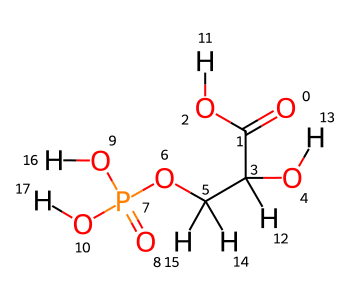

In [11]:
smi='O=C([O-])C(O)COP(=O)([O-])[O-]'
solver=RunPkasolver(smi)
for n,p,ds,ps,i in solver:
        solver_pka=p
        solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx))
print(solver_dict)
NumberStructure(Chem.MolFromSmiles(smi))

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C(O)COP(=O)([O-])[O-]
{2.42: 10, 3.45: 2, 5.4: 4}


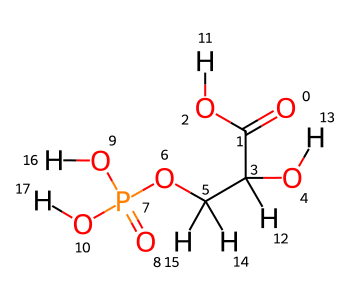

In [12]:
smi='O=C(O)C(O)COP(=O)(O)O'
#smi='O=C(O)C(O)COP(=O)(O)O'
solver=RunPkasolver(smi)
for n,p,ds,ps,i in solver:
        solver_pka=p
        solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx))
print(solver_dict)
NumberStructure(Chem.MolFromSmiles(smi))

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C(O)COP(=O)([O-])[O-]
{2.42: 10, 3.45: 2, 5.4: 4}


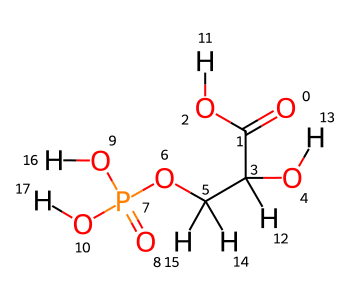

In [13]:
smi='OC(COP(O)(O)=O)C(O)=O'
solver=RunPkasolver(smi)
for n,p,ds,ps,i in solver:
        solver_pka=p
        solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx))
print(solver_dict)
NumberStructure(Chem.MolFromSmiles(smi))

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C[NH2+]CP(=O)([O-])O
{2.82: 2, 3.52: 9, 3.91: 8, 6.87: 4}


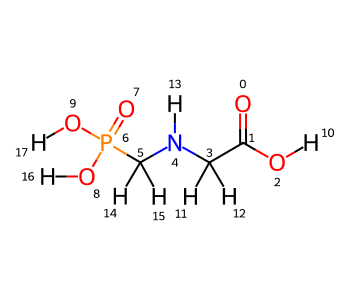

In [18]:
smi='OC(=O)CNCP(O)(O)=O'
solver=RunPkasolver(smi)
for n,p,ds,ps,i in solver:
        solver_pka=p
        solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx))
print(solver_dict)
NumberStructure(Chem.MolFromSmiles(smi))

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]COP(=O)([O-])[O-]
{2.58: 5, 3.67: 0}


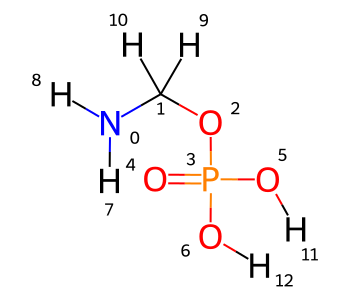

In [19]:
smi='NCOP(O)(O)=O'
solver=RunPkasolver(smi)
for n,p,ds,ps,i in solver:
        solver_pka=p
        solver_idx=i
solver_dict=dict(zip(solver_pka,solver_idx))
print(solver_dict)
NumberStructure(Chem.MolFromSmiles(smi))